In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Загрузка данных
data = pd.read_csv("AMAZON_FASHION.csv", sep=";", nrows=50000)
data_copy = data.copy()

In [ ]:
data_copy.info

<bound method DataFrame.info of              asin      reviewerID  overall  unixReviewTime
0      7106116521  A1D4G1SNUZWQOT      5.0      1413763200
1      7106116521  A3DDWDH9PX2YX2      2.0      1411862400
2      7106116521  A2MWC41EW7XL15      4.0      1408924800
3      7106116521  A2UH2QQ275NV45      2.0      1408838400
4      7106116521   A89F3LQADZBS5      3.0      1406419200
...           ...             ...      ...             ...
49995  B0012N84DY  A2F2F7N94SR1KQ      5.0      1501718400
49996  B0012N84DY  A1PF3HYKZM69T4      5.0      1501632000
49997  B0012N84DY   AAQ2RS80Y7QSR      5.0      1501372800
49998  B0012N84DY   A2DDLJPJCJM3O      5.0      1501286400
49999  B0012N84DY  A270B2UP0VF4NC      5.0      1501200000

[50000 rows x 4 columns]>

In [ ]:
data = data.drop_duplicates()

In [ ]:
data['overall'] = data['overall'].fillna(data['overall'].mean())

In [ ]:
scaler = MinMaxScaler()
data[['overall']] = scaler.fit_transform(data[['overall']])

In [ ]:
data.head()

,asin,reviewerID,overall,unixReviewTime
0,7106116521,A1D4G1SNUZWQOT,1.00,1413763200
1,7106116521,A3DDWDH9PX2YX2,0.25,1411862400
2,7106116521,A2MWC41EW7XL15,0.75,1408924800
3,7106116521,A2UH2QQ275NV45,0.25,1408838400
4,7106116521,A89F3LQADZBS5,0.50,1406419200


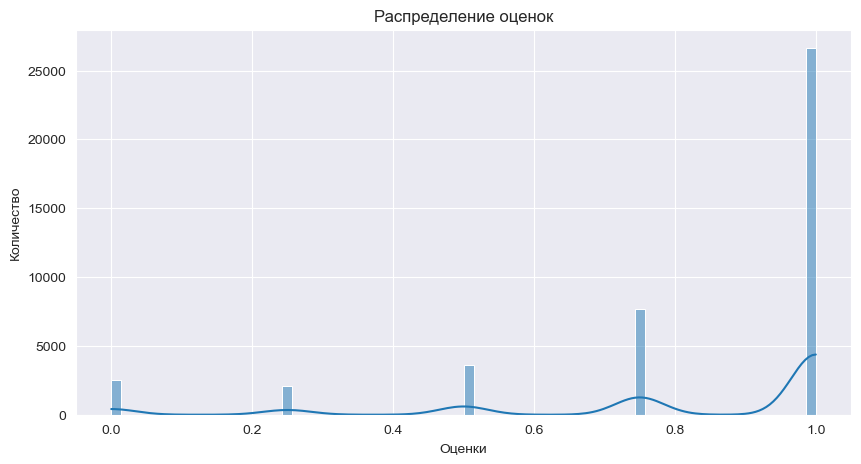

In [ ]:
# Гистограмма распределения оценок
plt.figure(figsize=(10, 5))
sns.histplot(data['overall'], kde=True)
plt.title("Распределение оценок")
plt.xlabel("Оценки")
plt.ylabel("Количество")
plt.show()

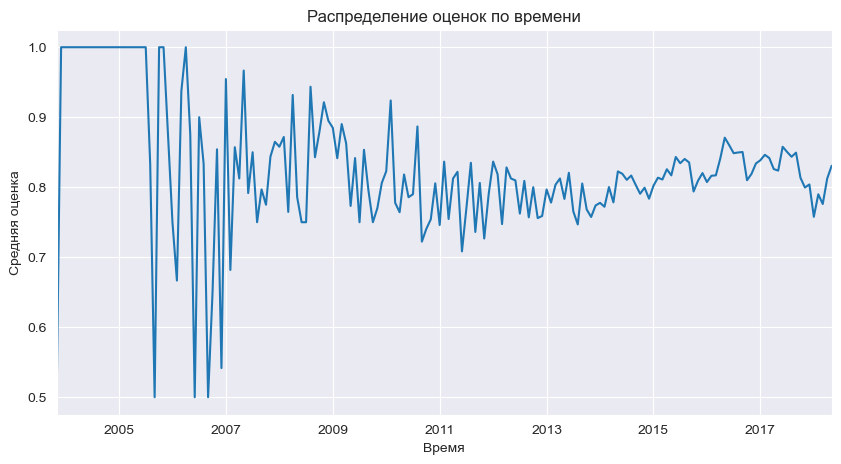

In [ ]:
# Распределение оценок по времени
data['datetime'] = pd.to_datetime(data['unixReviewTime'], unit='s')
plt.figure(figsize=(10, 5))
data.groupby(data['datetime'].dt.to_period('M'))['overall'].mean().plot()
plt.title("Распределение оценок по времени")
plt.xlabel("Время")
plt.ylabel("Средняя оценка")
plt.show()

In [ ]:
data_copy.head()


,asin,reviewerID,overall,unixReviewTime
0,7106116521,A1D4G1SNUZWQOT,5.0,1413763200
1,7106116521,A3DDWDH9PX2YX2,2.0,1411862400
2,7106116521,A2MWC41EW7XL15,4.0,1408924800
3,7106116521,A2UH2QQ275NV45,2.0,1408838400
4,7106116521,A89F3LQADZBS5,3.0,1406419200


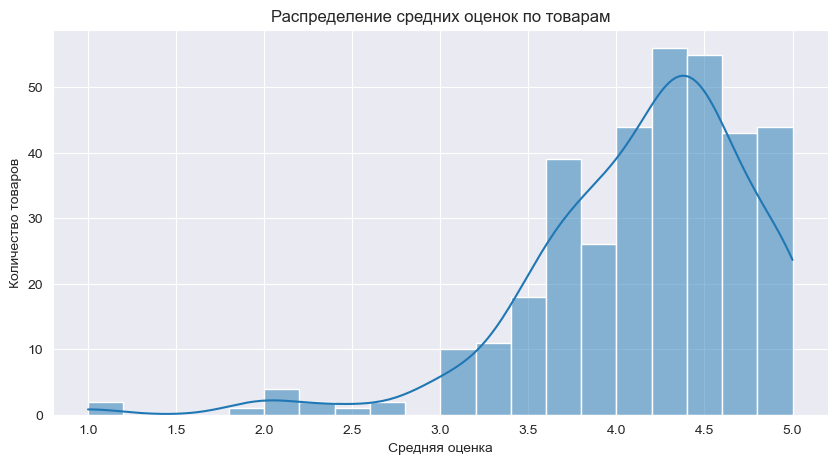

In [ ]:
# Группируем данные по 'asin' и вычисляем средние оценки
mean_ratings = data_copy.groupby('asin')['overall'].mean()

# Создаем график распределения средних оценок
plt.figure(figsize=(10, 5))
sns.histplot(mean_ratings, bins=20, kde=True)
plt.title("Распределение средних оценок по товарам")
plt.xlabel("Средняя оценка")
plt.ylabel("Количество товаров")
plt.show()


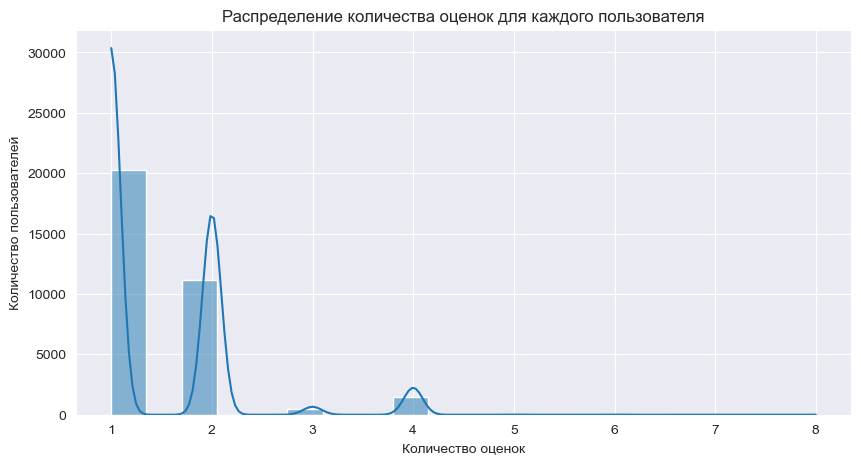

In [ ]:
reviews_per_user = data_copy.groupby('reviewerID')['overall'].count()

plt.figure(figsize=(10, 5))
sns.histplot(reviews_per_user, bins=20, kde=True)
plt.title("Распределение количества оценок для каждого пользователя")
plt.xlabel("Количество оценок")
plt.ylabel("Количество пользователей")
plt.show()


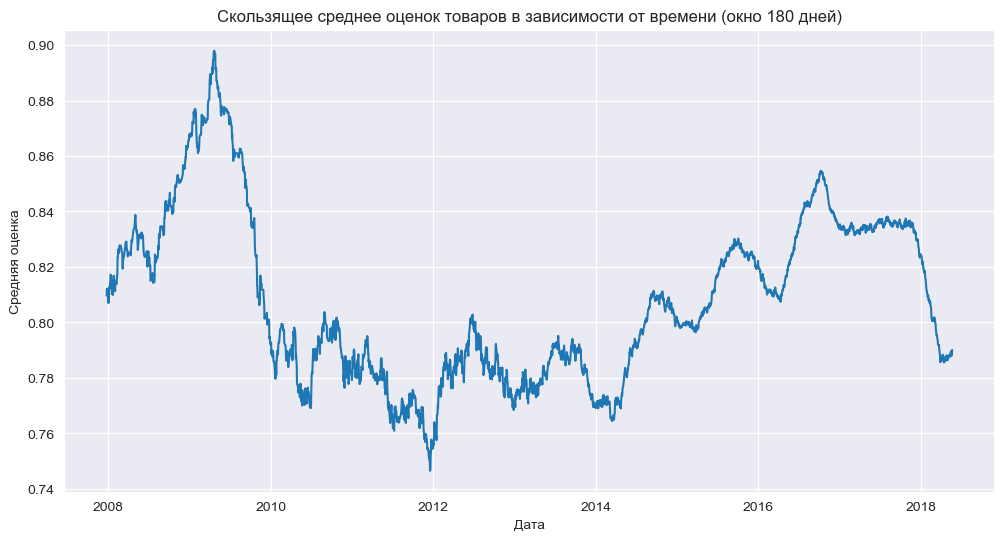

In [ ]:
data_copy['datetime'] = pd.to_datetime(data_copy['unixReviewTime'], unit='s')

average_rating_by_date = data.groupby(data_copy['datetime'].dt.date)['overall'].mean()

rolling_average = average_rating_by_date.rolling(window=180).mean()

plt.figure(figsize=(12, 6))
rolling_average.plot(kind='line')
plt.title("Скользящее среднее оценок товаров в зависимости от времени (окно 180 дней)")
plt.xlabel("Дата")
plt.ylabel("Средняя оценка")
plt.show()


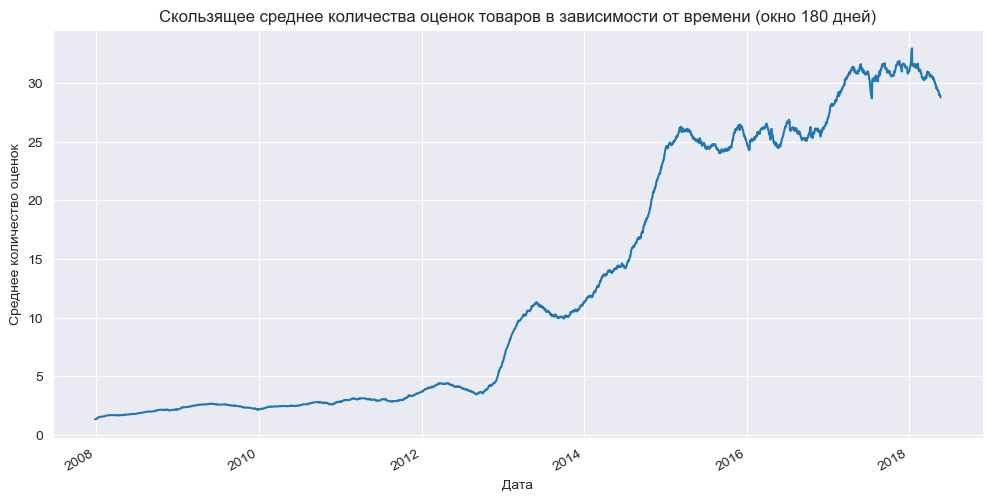

In [ ]:
# Группируем данные по дате и подсчитываем количество оценок для каждой даты
rating_count_by_date = data_copy.groupby('datetime')['overall'].count()

# Вычисляем скользящее среднее с окном в 180 дней
rolling_average_count = rating_count_by_date.rolling(window=180).mean()

# Создаем график скользящего среднего количества оценок товаров в зависимости от времени
plt.figure(figsize=(12, 6))
rolling_average_count.plot(kind='line')
plt.title("Скользящее среднее количества оценок товаров в зависимости от времени (окно 180 дней)")
plt.xlabel("Дата")
plt.ylabel("Среднее количество оценок")
plt.show()


In [ ]:
from surprise import Dataset, Reader, KNNBasic, KNNWithZScore, accuracy
from surprise.model_selection import train_test_split, GridSearchCV
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

In [ ]:
# Загрузка данных
data = data_copy.copy()
data['normalized_overall'] = data['overall'] / 5

# Задание формата данных для библиотеки Surprise
reader = Reader(rating_scale=(0, 1))
surprise_data = Dataset.load_from_df(data[['reviewerID', 'asin', 'normalized_overall']], reader)

# Разделение данных на обучающую и тестовую выборки
trainset, testset = train_test_split(surprise_data, test_size=0.2, random_state=42)

In [ ]:
# User-based коллаборативная фильтрация
user_based_cf = KNNWithZScore(k=40, sim_options={'name': 'pearson_baseline', 'user_based': True})
user_based_cf.fit(trainset)
user_based_preds = user_based_cf.test(testset)

# Item-based коллаборативная фильтрация
item_based_cf = KNNWithZScore(k=40, sim_options={'name': 'pearson_baseline', 'user_based': False})
item_based_cf.fit(trainset)
item_based_preds = item_based_cf.test(testset)


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [ ]:
# парсим json и добавляем нужную информацию о товарах для обучения по ней
import json
import pandas as pd
# Загрузка данных из JSON-файла
with open('meta_AMAZON_FASHION.json', 'r') as f:
    meta_data = json.load(f)

# Преобразование списка словарей в DataFrame
meta_df = pd.DataFrame(meta_data)

# Удаление всех столбцов, кроме 'asin', 'title', 'brand' и 'description'
meta_df = meta_df[['asin', 'title', 'brand', 'description']]

data_copy_2 = data_copy.copy()
# Объединение data и meta_df по столбцу 'asin'
data_copy_2 = data_copy_2.merge(meta_df, on='asin', how='left')

# Заполнение пропущенных значений в столбцах 'title', 'brand' и 'description' пустыми строками
data_copy_2['title'].fillna('', inplace=True)
data_copy_2['brand'].fillna('', inplace=True)
data_copy_2['description'].fillna('', inplace=True)

# Преобразование списков в столбце 'description' в строки
data_copy_2['description'] = data_copy_2['description'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# Объединение 'title', 'brand' и 'description' в один столбец 'content'
data_copy_2['content'] = data_copy_2['title'] + ' ' + data_copy_2['brand'] + ' ' + data_copy_2['description']
data_copy_2 = data_copy_2[data_copy_2['content'].apply(lambda x: len(x) <= 500)]


In [ ]:
data_copy_2_sample = data_copy_2.sample(n=30000, random_state=42)
data_copy_2_sample.to_csv('data_copy_2.csv', index=False, encoding='utf-8')

In [ ]:
# Создание нового DataFrame с тестовыми данными
test_df = pd.DataFrame(testset, columns=['reviewerID', 'asin', 'overall'])

# Удаление дубликатов из 'data_copy_2' по столбцу 'asin'
data_copy_2_unique = data_copy_2.drop_duplicates(subset='asin', keep='first')

# Объединение 'test_df' и 'data_copy_2_unique'
test_df = pd.merge(test_df, data_copy_2_unique[['asin', 'content']], on='asin', how='left')


In [ ]:
# Заполнение пропущенных значений в столбце 'content' пустыми строками
test_df['content'].fillna('', inplace=True)

# Извлечение признаков из данных о товарах (используем столбец 'content')
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(test_df['content'])

# Обучение модели машинного обучения для предсказания пользовательских оценок на основе признаков товаров
content_based_model = LinearRegression()
content_based_model.fit(tfidf_matrix, test_df['overall'])

# Прогнозирование оценок на основе контентно-основанного подхода
content_based_preds = content_based_model.predict(tfidf_matrix)

In [ ]:
# Нормализация оценок, полученных от каждого метода
def normalize_predictions(predictions):
    return (predictions - np.min(predictions)) / (np.max(predictions) - np.min(predictions))

user_based_norm_preds = normalize_predictions(np.array([pred.est for pred in user_based_preds]))
item_based_norm_preds = normalize_predictions(np.array([pred.est for pred in item_based_preds]))
content_based_norm_preds = normalize_predictions(content_based_preds)


# Взвешивание оценок от каждого метода на основе их эффективности и точности
# Предположим, что веса были определены на основе кросс-валидации или других экспериментов
# user_based_weight = 0 #0.4
# item_based_weight = 0 #0.3
# content_based_weight = 1 #0.3

user_based_weight = 0.45
item_based_weight = 0.45
content_based_weight = 1

# Агрегация оценок для формирования окончательных рекомендаций
final_preds = user_based_weight * user_based_norm_preds + item_based_weight * item_based_norm_preds + content_based_weight * content_based_norm_preds


# Оценка точности предсказаний с использованием средней абсолютной ошибки (MAE)
mae = np.mean(np.abs(final_preds - np.array([pred.r_ui for pred in user_based_preds])))
print("Mean Absolute Error:", mae)

Mean Absolute Error: 0.11070446892316807


In [ ]:
from sklearn.metrics import mean_squared_error
from collections import defaultdict
from sklearn.metrics import average_precision_score

def rmse(predictions, ground_truth):
    return np.sqrt(mean_squared_error(predictions, ground_truth))

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

def f1_score_at_k(precisions, recalls):
    f1_scores = dict()
    for uid in precisions.keys():
        f1_scores[uid] = (2 * precisions[uid] * recalls[uid]) / (precisions[uid] + recalls[uid]) if (precisions[uid] + recalls[uid]) != 0 else 0
    return f1_scores

def mean_average_precision(predictions, threshold=3.5):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    ap_values = []
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        true_ratings = [true_r for (_, true_r) in user_ratings]
        est_ratings = [est for (est, _) in user_ratings]
        if any(np.array(true_ratings) >= threshold):
            ap_values.append(average_precision_score(np.array(true_ratings) >= threshold, est_ratings))

    return np.mean(ap_values)


    return np.mean(ap_values)


In [ ]:
# Преобразование предсказаний для использования в функциях метрик
predictions_for_metrics = [(pred.uid, pred.iid, pred.r_ui, final_preds[i], {}) for i, pred in enumerate(user_based_preds)]

# Вычисление метрик
rmse_value = rmse(final_preds, np.array([pred.r_ui for pred in user_based_preds]))
precisions, recalls = precision_recall_at_k(predictions_for_metrics, k=10, threshold=0.7)
f1_scores = f1_score_at_k(precisions, recalls)
map_value = mean_average_precision(predictions_for_metrics, threshold=0.7)

# Вывод результатов
print("RMSE:", rmse_value)
print("Precision@10:", np.mean(list(precisions.values())))
print("Recall@10:", np.mean(list(recalls.values())))
print("F1-score@10:", np.mean(list(f1_scores.values())))
print("Mean Average Precision:", map_value)

# user_based_weight = 0
# item_based_weight = 0
# content_based_weight = 1

RMSE: 0.23386144316812174
Precision@10: 0.8368386816999133
Recall@10: 0.9372289679098005
F1-score@10: 0.7741037872217404
Mean Average Precision: 0.9998091082628853


In [ ]:
# Преобразование предсказаний для использования в функциях метрик
predictions_for_metrics = [(pred.uid, pred.iid, pred.r_ui, final_preds[i], {}) for i, pred in enumerate(user_based_preds)]

# Вычисление метрик
rmse_value = rmse(final_preds, np.array([pred.r_ui for pred in user_based_preds]))
precisions, recalls = precision_recall_at_k(predictions_for_metrics, k=10, threshold=0.7)
f1_scores = f1_score_at_k(precisions, recalls)
map_value = mean_average_precision(predictions_for_metrics, threshold=0.7)

# Вывод результатов
print("RMSE:", rmse_value)
print("Precision@10:", np.mean(list(precisions.values())))
print("Recall@10:", np.mean(list(recalls.values())))
print("F1-score@10:", np.mean(list(f1_scores.values())))
print("Mean Average Precision:", map_value)

# user_based_weight = 0.4
# item_based_weight = 0.3
# content_based_weight = 0.3

RMSE: 0.17047714297300712
Precision@10: 0.900531222896791
Recall@10: 0.9985364267129229
F1-score@10: 0.8991399248337669
Mean Average Precision: 0.9998045632215253


In [ ]:
# Преобразование предсказаний для использования в функциях метрик
predictions_for_metrics = [(pred.uid, pred.iid, pred.r_ui, final_preds[i], {}) for i, pred in enumerate(user_based_preds)]

# Вычисление метрик
rmse_value = rmse(final_preds, np.array([pred.r_ui for pred in user_based_preds]))
precisions, recalls = precision_recall_at_k(predictions_for_metrics, k=10, threshold=0.7)
f1_scores = f1_score_at_k(precisions, recalls)
map_value = mean_average_precision(predictions_for_metrics, threshold=0.7)

# Вывод результатов
print("RMSE:", rmse_value)
print("Precision@10:", np.mean(list(precisions.values())))
print("Recall@10:", np.mean(list(recalls.values())))
print("F1-score@10:", np.mean(list(f1_scores.values())))
print("Mean Average Precision:", map_value)
# user_based_weight = 0.5
# item_based_weight = 0.5
# content_based_weight = 0

RMSE: 0.17308944301285634
Precision@10: 0.8981461405030355
Recall@10: 0.9983196010407632
F1-score@10: 0.8965380167678519
Mean Average Precision: 0.9998045632215253


In [ ]:
# Преобразование предсказаний для использования в функциях метрик
predictions_for_metrics = [(pred.uid, pred.iid, pred.r_ui, final_preds[i], {}) for i, pred in enumerate(user_based_preds)]

# Вычисление метрик
rmse_value = rmse(final_preds, np.array([pred.r_ui for pred in user_based_preds]))
precisions, recalls = precision_recall_at_k(predictions_for_metrics, k=10, threshold=0.7)
f1_scores = f1_score_at_k(precisions, recalls)
map_value = mean_average_precision(predictions_for_metrics, threshold=0.7)

# Вывод результатов
print("RMSE:", rmse_value)
print("Precision@10:", np.mean(list(precisions.values())))
print("Recall@10:", np.mean(list(recalls.values())))
print("F1-score@10:", np.mean(list(f1_scores.values())))
print("Mean Average Precision:", map_value)
# user_based_weight = 0.45
# item_based_weight = 0.45
# content_based_weight = 1

RMSE: 0.17308944301285634
Precision@10: 0.8981461405030355
Recall@10: 0.9983196010407632
F1-score@10: 0.8965380167678519
Mean Average Precision: 0.9998045632215253
